## Animal face graph

This notebook shows an example how to: 
* Load images and get ResNet-50 feature vectors for the images
* Construct a graph of the image data
* Arrange the graph plot so that the vertices (images) are positioned according to their feature relations. 
* Find path between vertices in the graph and plot images from that path. 

(c) Mikko Kursula 2018. MIT Licence. 

In [ ]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.applications.resnet50 import ResNet50, preprocess_input

# Own modules
from graph import Graph
from graphutils import GraphUtils

### Define image processing functions

In [2]:
def get_model():
    model = ResNet50(weights='imagenet', include_top=False)
    return model
    
def load_image(image_path, target_size=(224, 224)):
    # TODO: load error handling
    img = cv2.imread(image_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       
    img = cv2.resize(img, dsize=target_size)
    return img

def get_thumbnail(image, target_size):
    tn = cv2.resize(image.copy(), dsize=target_size)
    return tn

def get_img_feature_vector(model, image): 
    img = preprocess_input(image.copy().astype(np.float32))
    vect = model.predict(np.expand_dims(img, axis=0), verbose=0)[0, 0, 0]
    return vect

def reduce_vect_dim(vectors, dim):
    pca = PCA(n_components=dim)
    reduced = pca.fit_transform(vectors.copy())
    return reduced


def load_and_process_images(folder_path):
    thumbnails = []
    thumbnail_size = (50, 50)
    feature_vectors = []

    # Get image paths
    img_paths = glob.glob(folder_path, recursive=True)
    n_images = len(img_paths)
    
    model = get_model()

    # Process all images 
    for i in range(n_images):
        img = load_image(img_paths[i])
        tn = get_thumbnail(img, thumbnail_size)
        fvector = get_img_feature_vector(model, img)
        thumbnails.append(tn)
        feature_vectors.append(fvector)

    feature_vectors = reduce_vect_dim(feature_vectors, dim=6)
    return img_paths, feature_vectors, thumbnails
    

### Load and process all images

In [3]:
animal_faces = "animals/*/*.png"
img_paths, feature_vectors, thumbnails = load_and_process_images(animal_faces)
n_images = len(img_paths)

### Greate the graph  

In [8]:
gr = Graph()
for i in range(n_images):
    gr.add_vertex(key=i, feature_vector=feature_vectors[i], 
                  image=thumbnails[i],
                  description=img_paths[i])    


### Optimize the graph layout. 

Layout is optimized using gradient descent algorithm that arranges the vertex locations. The algorithm tries to position vertices so that the distance between the vertices in the x,y coordinate system is same as their feature vector Euclidean distance. Any distance error is summed to stress result that indicated the 'quality' of the layout. With 2-dimensional feature vectors the graph layout can achieve almost zero stress, but with higher dimensional feature vectors there will be always some residual stress. 

The graph edges are defined using Delaunay triangulation. It connects each vertex to the nearest vertices so that there will be no overlapping or crossing edges. The edge connections can be done either based on the vertex location or feature vectors (if the feature vectors are low dimensional, typically <8).

 
Iteration 0 [====================>] stress = 109962.65    
Iteration 1 [====================>] stress = 86069.19    
Iteration 2 [====================>] stress = 71532.49    
Iteration 3 [====================>] stress = 61309.17    
Iteration 4 [====================>] stress = 54605.80    
Iteration 5 [====================>] stress = 49720.36    
Iteration 6 [====================>] stress = 45962.64    
Iteration 7 [====================>] stress = 42187.25    
Iteration 8 [====================>] stress = 39075.82    
Iteration 9 [====================>] stress = 36669.73    
Iteration 10 [====================>] stress = 35045.59    
Iteration 11 [====================>] stress = 34077.44    
Iteration 12 [====================>] stress = 33252.59    
Iteration 13 [====================>] stress = 32589.37    
Iteration 14 [====================>] stress = 32002.55    
Iteration 15 [====================>] stress = 31288.20    
Iteration 16 [====================>] stress = 30573.74    
Iter

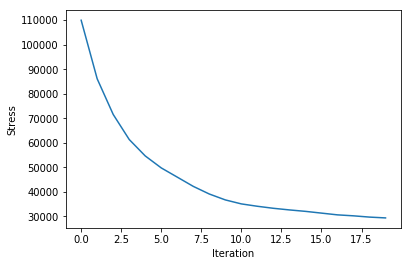

In [9]:
# Greate utilities object
gr_utils = GraphUtils()

# Optimize the vertex layout and plot the stress curve
stress = gr_utils.arrange_vertices(graph=gr, iterations=20, lr=10, verbose=True)
plt.plot(stress)
plt.xlabel('Iteration')
plt.ylabel('Stress')
plt.show()

# Define graph edges using Delaunay triangulation
gr_utils.define_edges(graph=gr, method='location')

### Find a path in the graph and plot the graph
The graph path search uses modified Dijkstra's algorithm that takes the edge distances into account. Basically the path means the steps through the graph from the starting vertex to the end vertex. The intermediate steps will be taken through vertices that are most similar to each other. In a very large and dense graph the path steps will form a smooth transition from the starting vertex image to the end vertex image. The path can be highlighted (red) when plotting the graph.

The thumbnail images defined earlier can be used to visualize the vertices when plotting the graph (set plot_images to True). 

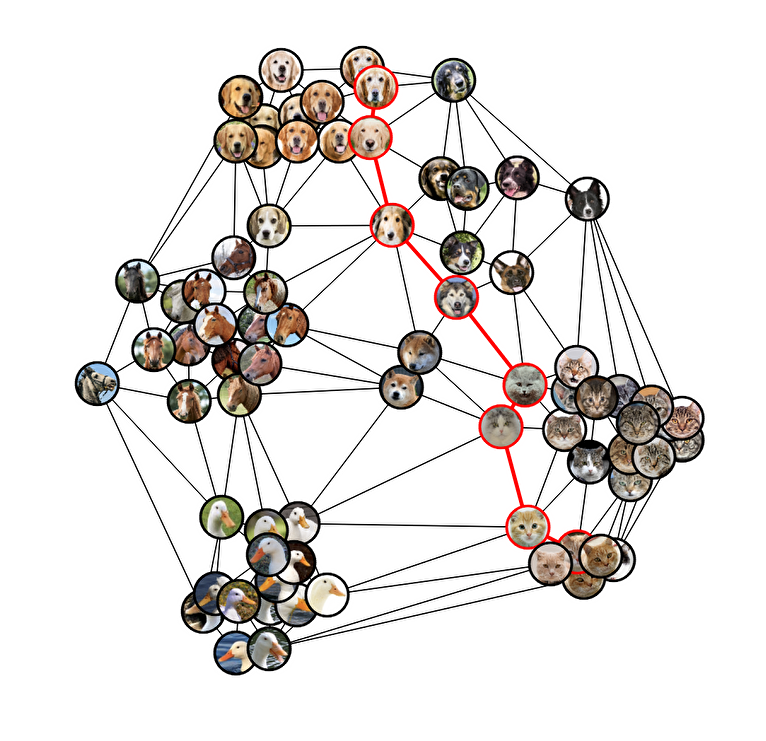

In [16]:
# Find the path in the graph
pathlist = gr_utils.find_shortest_path(graph=gr, key_a=6, key_b=50)

# Plot everything
gr_utils.plot_graph(graph=gr, path_list=pathlist, 
                    save=True, filename='output.png',
                    plot_edges=True, 
                    plot_path=True,
                    plot_images=True,
                    vertex_radius=30,
                    img_x=1000, img_y=1000)

### Plot the images on the path that was found earlier
When defining the graph the file paths were saved in the vertex descriptions. Those paths are now used to load the original images. 

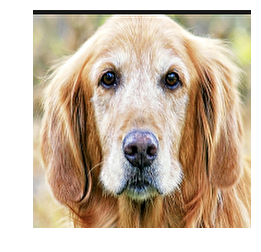

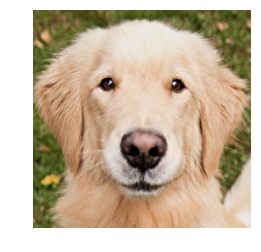

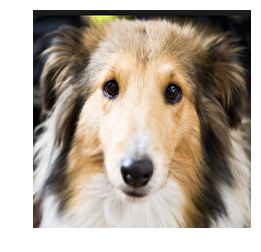

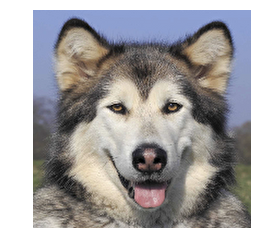

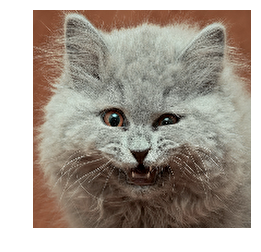

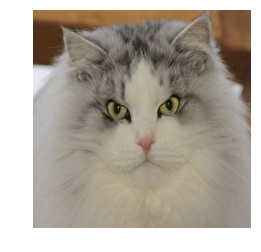

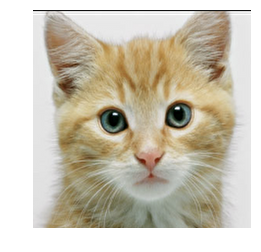

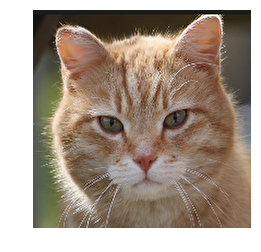

In [21]:
for key in pathlist:
    img_path = gr.get_description(key)
    img = load_image(img_path, target_size=(200, 200))
    plt.imshow(img, interpolation='sinc')
    plt.axis('off')
    plt.show()